Title: Convolutional autoencoder for image denoising
Author: [Santiago L. Valdarrama](https://twitter.com/svpino)
Date created: 2021/03/01
Last modified: 2021/03/01
Description: How to train a deep convolutional autoencoder for image denoising.



## Introduction

This example demonstrates how to implement a deep convolutional autoencoder
for image denoising, mapping noisy digits images from the MNIST dataset to
clean digits images. This implementation is based on an original blog post
titled [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
by [François Chollet](https://twitter.com/fchollet).

## Setup

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, boston_housing, fashion_mnist
from tensorflow.keras.models import Model
import pandas as pd

In [2]:
import numpy as np

def appendSpherical_np(xyz):
    ptsnew = np.hstack((xyz, np.zeros(xyz.shape)))
    xy = xyz[:,0]**2 + xyz[:,1]**2
    ptsnew[:,3] = np.sqrt(xy + xyz[:,2]**2)
    # ptsnew[:,4] = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
    ptsnew[:,4] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    ptsnew[:,5] = np.arctan2(xyz[:,1], xyz[:,0])
    return ptsnew


In [3]:


# def toSpherical(df):

#     theta = np.arctan2(np.sqrt(df['-X']**2 + df['Y']**2), df['Z'])

#     phi = np.arctan2(df['Y'],  df['-X'])
    
#     r = np.sqrt(df['-X']**2 + df['Y']**2 + df['Z']**2)
    
#     return (r, theta, phi)

# def toCartesian(df):
#     x = self.r*np.cos(self.phi)*sin(self.theta)
#     y = self.r*np.sin(self.phi)*sin(self.theta)
#     z = self.r*np.cos(self.theta)
#     return Pt(x,y,z)

## Prepare the data

In [175]:

class AutoEncoder():
    
    def __init__(self, filname = '1_.txt', modality = 'Radar', dataset_directory='/home/artin/Documents/10dB_CR_10deg_in_2021-10-15-14-15-49'):

        self.filename = filname
        self.modality = modality
        self.dataset_directory = dataset_directory
        self.dir = f'{dataset_directory}/{modality}/{filname}'
        
    def get_dataframe(self, columns: dict={'Range Index':'Range', 'Azimuth Index':'Azimuth', 'Elevation Index':'Elevation', 'Amplitude Index':'Amplitude', 'RCS':'RCS', 'Velocity Index':'Velocity'}):
        
        def _read_data():
            self.dataframe_original = pd.read_csv(self.dir)        
            self.dataframe_original.columns = ['Frame ID', 'Pocket ID' , 'Y', '-X', 'Z', 'Range', 'Azimuth Angle', 'Elevation Angle', 'RCS' , 'Velocity' , 'Range Index', 'Azimuth Index', 'Elevation Index', 'Velocity Index', 'Amplitude Index', 'Timestamp', 'Temperature', '?']
            self.dataframe = self.dataframe_original.copy()
            
        def _filter_columns(columns: list):
            self.dataframe = self.dataframe[columns]
            
        def _rename_columns(columns: dict):
            self.dataframe.rename(columns=columns, inplace=True)
                    
        _read_data()
        _filter_columns( columns=columns.keys() )
        _rename_columns( columns=columns )
        
    def conversion_to_3D( self , matrix_dimentions={'Range':600, 'Azimuth':180, 'Elevation':20}, matrix_value='Amplitude'):
        
        ''' Range is assumed to be in the range [0, 600]
            Elevation Angle is in the range [-10, 10]
            Azimuth angle is in the range [0, 180]
            matrix_value can either be an integer/float or a string that corresponds to a column name. It's value will be used to fill the matrix. '''
        
        
        # Creating an empty array to store the data        
        self.data_3d = np.zeros( list(matrix_dimentions.values()) )
        
        # Shifting the Elevation values to the range (0, 20)
        self.dataframe.Elevation += 10
        
                
        x,y,z = matrix_dimentions.keys()
        
        for _, row in self.dataframe.iterrows():
            self.data_3d [ int(row[x]) ] [ int(row[y]) ] [ int(row[z]) ] = row[matrix_value] if isinstance(matrix_value,str) else matrix_value
            
                    
        return self.data_3d
     
    def normalizing_to_0_1( self, normalization_values = {'Range':1000, 'Azimuth':180, 'Elevation':20, 'RCS':100, 'Velocity':200, 'Amplitude':100000} ):

        self.dataframe_normalized = self.dataframe.copy()
        
        for key, value in normalization_values.items():
            self.dataframe_normalized[key] /= value
        
        self.dataframe_normalized.Elevation += 0.5
        self.dataframe_normalized.Velocity  += 0.5
    
        return self.dataframe_normalized
    
    def get_data(self, data_type='vector'):
        ''' data_type can be 'vector' or 'matrix' '''
        
        self.get_dataframe()
        
        if data_type == 'vector':   return self.normalizing_to_0_1()
        
        elif data_type == 'matrix': return self.conversion_to_3D( matrix_dimentions={'Range':600, 'Azimuth':180, 'Elevation':20}, matrix_value=1)
        
        else: raise ValueError('data_type can be either "vector" or "matrix"')
        
    
autoencoder = AutoEncoder()
data = autoencoder.get_data(data_type='vector')

data


,Range,Azimuth,Elevation,Amplitude,RCS,Velocity
0,0.001,0.172222,0.8,0.18606,0.853931,0.500
1,0.001,0.300000,0.1,0.00143,0.431067,0.755
2,0.001,0.305556,0.1,0.00118,0.414376,0.755
3,0.001,0.311111,0.4,0.00103,0.402567,0.755
4,0.001,0.313889,0.4,0.00106,0.405061,0.755
...,...,...,...,...,...,...
1061,0.497,0.261111,0.6,0.01537,0.637335,0.500
1062,0.498,0.244444,0.4,0.01299,0.622722,0.500
1063,0.499,0.258333,0.8,0.01335,0.625096,0.500
1064,0.507,0.102778,0.7,0.01300,0.622789,0.810


In [ ]:
train_data = data.sample(frac=0.8, random_state=1)
test_data = data.drop(train_data.index)

## Build the autoencoder

We are going to use the Functional API to build our convolutional autoencoder.

In [7]:
input = layers.Input(shape=(data.shape[1], 1))

# Encoder
x = layers.Conv1D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu')(input)
x = layers.Conv1D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = layers.Conv1D(filters=512, kernel_size=3, strides=2, padding='same', activation='relu')(x)

# Decoder
x = layers.Conv1DTranspose(filters=256, strides=2, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv1DTranspose(filters=256, strides=1, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv1DTranspose(filters=1,   strides=1, kernel_size=3, padding='same', activation='sigmoid')(x)


# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

2022-06-28 16:21:29.865148: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-28 16:21:29.865464: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-28 16:21:29.868341: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 1)]            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 6, 256)            1024      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6, 512)            393728    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 512)            786944    
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 6, 256)            393472    
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 6, 256)            196864    
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 6, 1)              769   

Now we can train our autoencoder using `train_data` as both our input data
and target. Notice we are setting up the validation data using the same
format.

In [15]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=5,
    batch_size=10,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/5
86/86 [==============================] - 5s 64ms/step - loss: 0.4510 - val_loss: 0.4562
Epoch 2/5
86/86 [==============================] - 4s 51ms/step - loss: 0.4510 - val_loss: 0.4560
Epoch 3/5
86/86 [==============================] - 5s 59ms/step - loss: 0.4510 - val_loss: 0.4561
Epoch 4/5
86/86 [==============================] - 5s 54ms/step - loss: 0.4509 - val_loss: 0.4561
Epoch 5/5
86/86 [==============================] - 3s 39ms/step - loss: 0.4508 - val_loss: 0.4561


Let's predict on our test dataset and display the original image together with
the prediction from our autoencoder.

Notice how the predictions are pretty close to the original images, although
not quite the same.

In [9]:
predictions = autoencoder.predict(test_data)
predictions = pd.DataFrame(predictions[:,:,0], columns=test_data.columns, index=test_data.index)
predictions

,Range Index,Azimuth Index,Elevation Index,RCS,Velocity Index,Amplitude Index
10,0.007426,0.420209,0.307115,0.450542,0.738906,0.002870
15,0.006752,0.531630,0.211910,0.494965,0.248437,0.005939
20,0.005989,0.588174,0.106692,0.449314,0.627883,0.003037
21,0.006388,0.603711,0.102637,0.496809,0.247253,0.005874
22,0.007203,0.631099,0.304115,0.499533,0.249330,0.006142
...,...,...,...,...,...,...
1037,0.367585,0.596626,0.090469,0.629899,0.502655,0.011706
1044,0.364505,0.259979,0.600284,0.600833,0.499223,0.010282
1056,0.439889,0.118029,0.601372,0.664313,0.498183,0.021939
1061,0.491373,0.255154,0.604820,0.623667,0.496294,0.014784


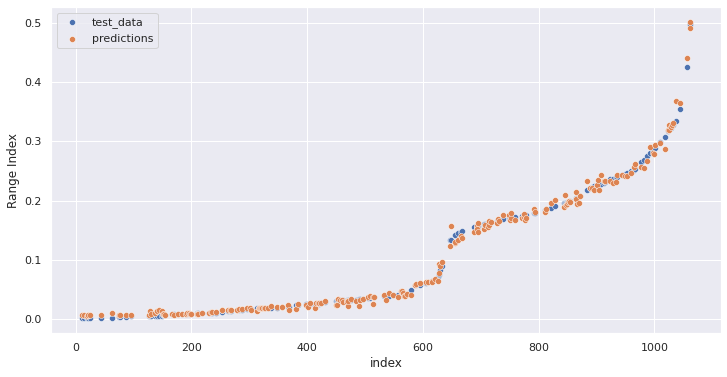

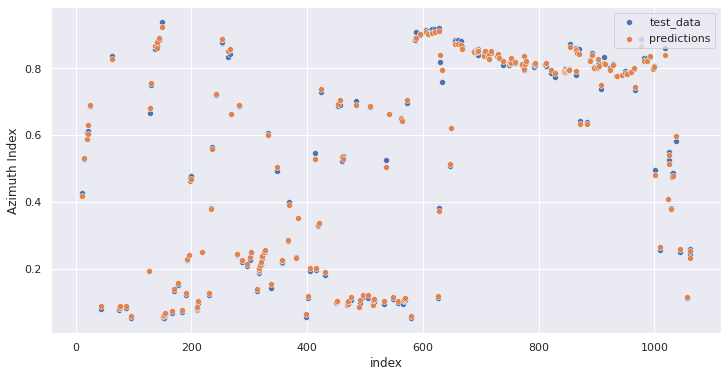

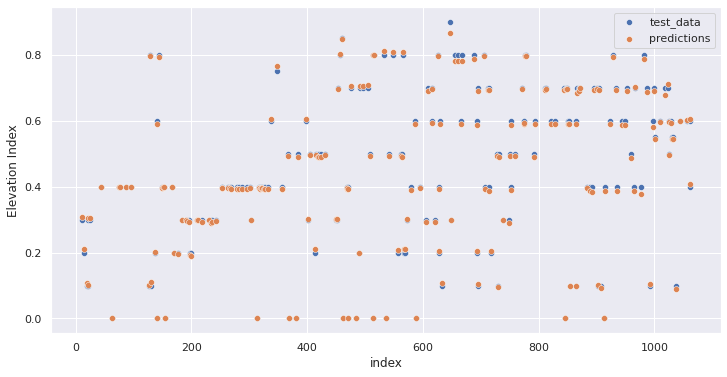

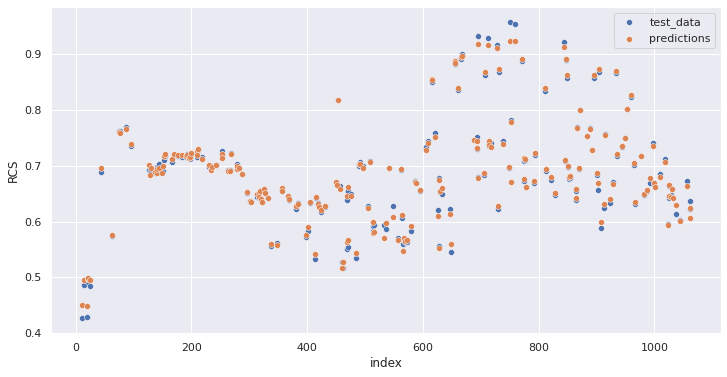

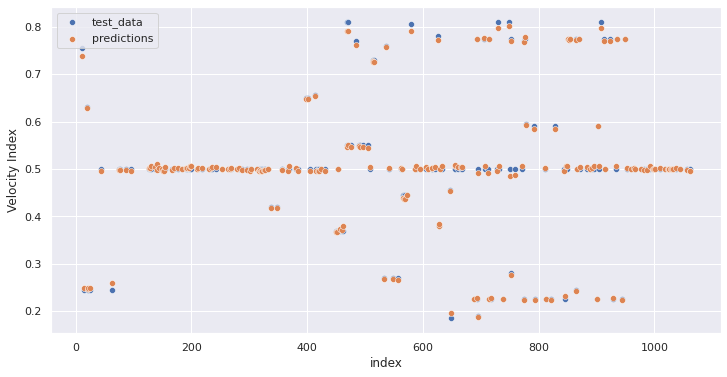

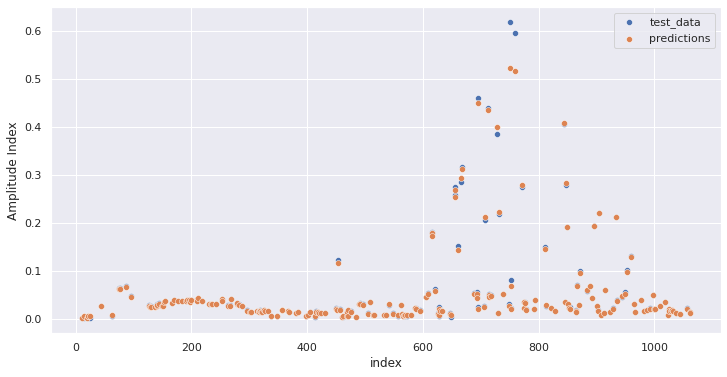

In [10]:
import seaborn as sns

test_data2 = test_data.reset_index()
predictions2 = predictions.reset_index()

sns.set()
for y in test_data2.columns[1:]:

    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='index', y=y, data=test_data2, label='test_data')
    sns.scatterplot(x='index', y=y, data=predictions2, label='predictions')
    plt.legend()
    plt.xlabel('index')
    plt.show()
    



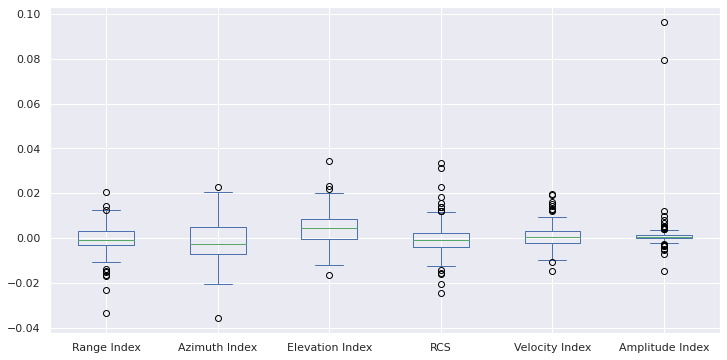

In [11]:
(test_data2-predictions2)[data.columns].plot(kind='box', figsize=(12, 6))
plt.show()

Now that we know that our autoencoder works, let's retrain it using the noisy
data as our input and the clean data as our target. We want our autoencoder to
learn how to denoise the images.